In [1]:
import numpy as np
# import random
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import scipy.optimize

import warnings
warnings.filterwarnings("ignore")

Given the reservoir with 1 injection and 4 producing wells data history, use CRMP representation of the Capacitance Resistance Model to match historical data and calculate predictions:

$$\hat{q}_j (t_n) = \lambda_{pj} q_j (t_0) e^{-\frac{(t_n - t_0)}{\tau_{pj}}} + \sum^I_{i=1} \lambda_{ij}\sum^n_{m=0} \left(1-e^{-\frac{\Delta t_m}{\tau_j}}\right) e^{-\frac{t_n - t_m}{\tau_j}} i_i(t_m), j=1,\dots,P,$$

$t_0, t_n$ -- the first and the last time steps
$q_j$ -- liquid production rate of j-th producing well
$i_i$ -- injection rate of i-th injector
$\Delta t_m = t_m - t_{m-1}, \Delta t_0 = 0$

### Task 1:

Divide the given dataset on training and testing sets (try at least three different ratios), then tune the model parameters $\lambda_{pj}, \tau_{pj}, \tau_j$ (using existing optimization packages or your own optimization scheme) on the training set and make forecasts for the testing set. Plot the results.

In [3]:
data = pd.read_excel('data.xlsx', 'Sheet1')

In [4]:
data.head()

,Date,I01,P01,P02,P03,P04
0,2005-12-31,0,0.000000,0.000000,0.000000,0.000000
1,2006-01-30,100,148.929253,148.929282,148.929382,148.929306
2,2006-03-01,100,91.320024,91.319542,91.319315,91.319354
3,2006-03-31,100,64.925984,64.925856,64.925761,64.925798
4,2006-04-30,100,48.562603,48.562865,48.562994,48.562919


In [5]:
injection_rates = data.loc[:, ['I01']].values
production_rates = data.loc[:, ['P01', 'P02', 'P03', 'P04']].values
dates = data['Date'].values

In [6]:
production_rates.shape, injection_rates.shape

((81, 4), (81, 1))

In [7]:
dt = np.hstack(([1.], pd.to_timedelta(dates[1:] - dates[:-1]).days/30))
dt_cum = dt.cumsum()
dt_cum[80]

81.0

$$\hat{q}_j (t_n) = \lambda_{pj} q_j (t_0) e^{-\frac{(t_n - t_0)}{\tau_{pj}}} + \sum^I_{i=1} \lambda_{ij}\sum^n_{m=0} \left(1-e^{-\frac{\Delta t_m}{\tau_j}}\right) e^{-\frac{t_n - t_m}{\tau_j}} i_i(t_m), j=1,\dots,P,$$

$t_0, t_n$ -- the first and the last time steps
$q_j$ -- liquid production rate of j-th producing well
$i_i$ -- injection rate of i-th injector
$\Delta t_m = t_m - t_{m-1}, \Delta t_0 = 0$

In [8]:
def model_function(x, parameters):
    out = np.zeros((x.shape[0], 4))
    for t in range(x.shape[0]):
        prime_term = parameters[:4] * production_rates[1, :] * np.exp(-(x[t] - x[1]) / parameters[4:8])
        conv_inj = np.zeros(4)
        for m in range(t + 1):
            if m == 0:
                conv_inj = 0
            else:
                conv_inj += (1 - np.exp(-(x[m] - x[m-1]) / parameters[12:])) * np.exp(-(x[t] - x[m]) / parameters[12:]) * injection_rates[m]
        out[t, :] = prime_term + parameters[8:12] * conv_inj
    return out

In [9]:
t_0, t_n = 1, 81
number_of_injector_wells, number_of_production_wells = 1, 4

In [10]:
ttsb = 50 #train_test_split_boundary

Note:

> Using the property of matrices norm $\Vert A \Vert^2_{F} = \sum^m_{i=1} \Vert a_i \Vert_2^2$ (which real analog of squared error)

In [11]:
# Write down the objective function to minimize
def obj_func(parameters, train_set, targets):
    preds = model_function(train_set, parameters)
    return np.linalg.norm(targets - preds, 'fro')**2 / (targets.shape[0]*targets.shape[1])

In [12]:
# Write down the initial guess for params of model_function
initial_guess = np.ones(16)

In [13]:
#Write down the bounds for the params
bnds = []
for i in range(16):
    if i<4 or (8<=i<12):
        bnds.append((0,1))
    else:
        bnds.append((0,None))

In [14]:
# scipy.optimize.minimize has lots of methods in the 'method' argument, you can try different ones
# Do not forget to fill the args argumnet required for the model_function
result = scipy.optimize.minimize(obj_func, initial_guess,
                                 bounds=bnds,
                                 args=(dt_cum[1:ttsb], production_rates[1:ttsb,:]),
                                 method='SLSQP')
np.reshape(result.x, (4,4))

array([[0.66155758, 0.58067901, 0.55564282, 0.58162013],
       [2.02614224, 1.95096092, 1.70610011, 1.88438399],
       [0.2327239 , 0.22812164, 0.22644252, 0.22779651],
       [1.47776156, 1.41822753, 1.39548823, 1.36790235]])

In [15]:
#Predict on the train and test values with optimization solution
modeled_rates = model_function(dt_cum[1:], result.x)

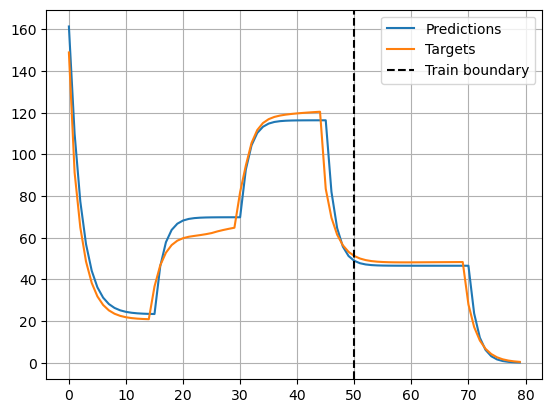

In [16]:
plt.plot(modeled_rates[:, 0], label='Predictions')
plt.plot(production_rates[t_0:, 0], label='Targets')
plt.axvline(x=ttsb, ls='--', color='k', label = 'Train boundary')
plt.grid()
plt.legend()
plt.show()

lambda_p: 
 [0.56289355 0.56288274 0.56289403 0.56289987]
tau_p: 
 [1.76891953 1.7688664  1.76890594 1.76892684]
lambda: 
 [0.22788572 0.2278858  0.2278851  0.22788559]
tau: 
 [1.49017014 1.49015437 1.49021208 1.49029197]


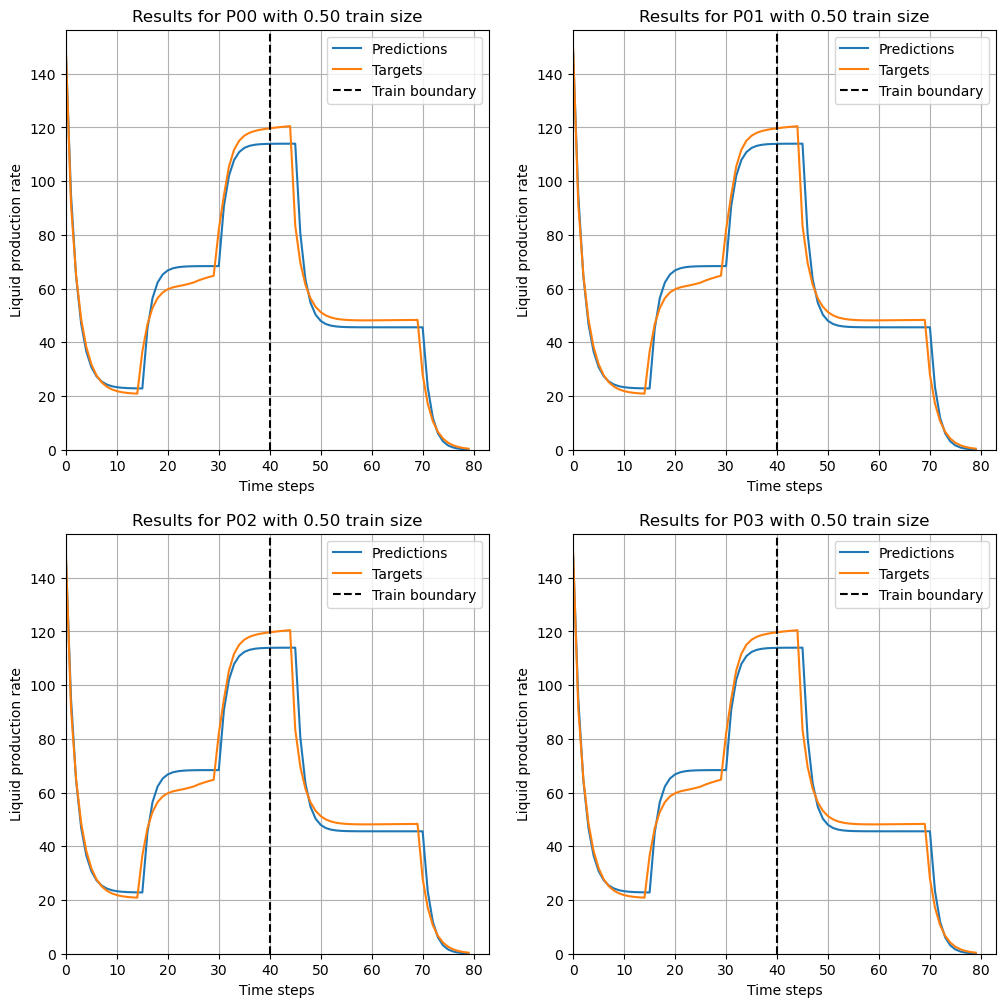

lambda_p: 
 [0.55816112 0.5581598  0.5581589  0.55816154]
tau_p: 
 [1.74463813 1.74463954 1.74463556 1.74464042]
lambda: 
 [0.22714301 0.22714283 0.22714281 0.22714252]
tau: 
 [1.32734011 1.32733216 1.32735706 1.32735788]


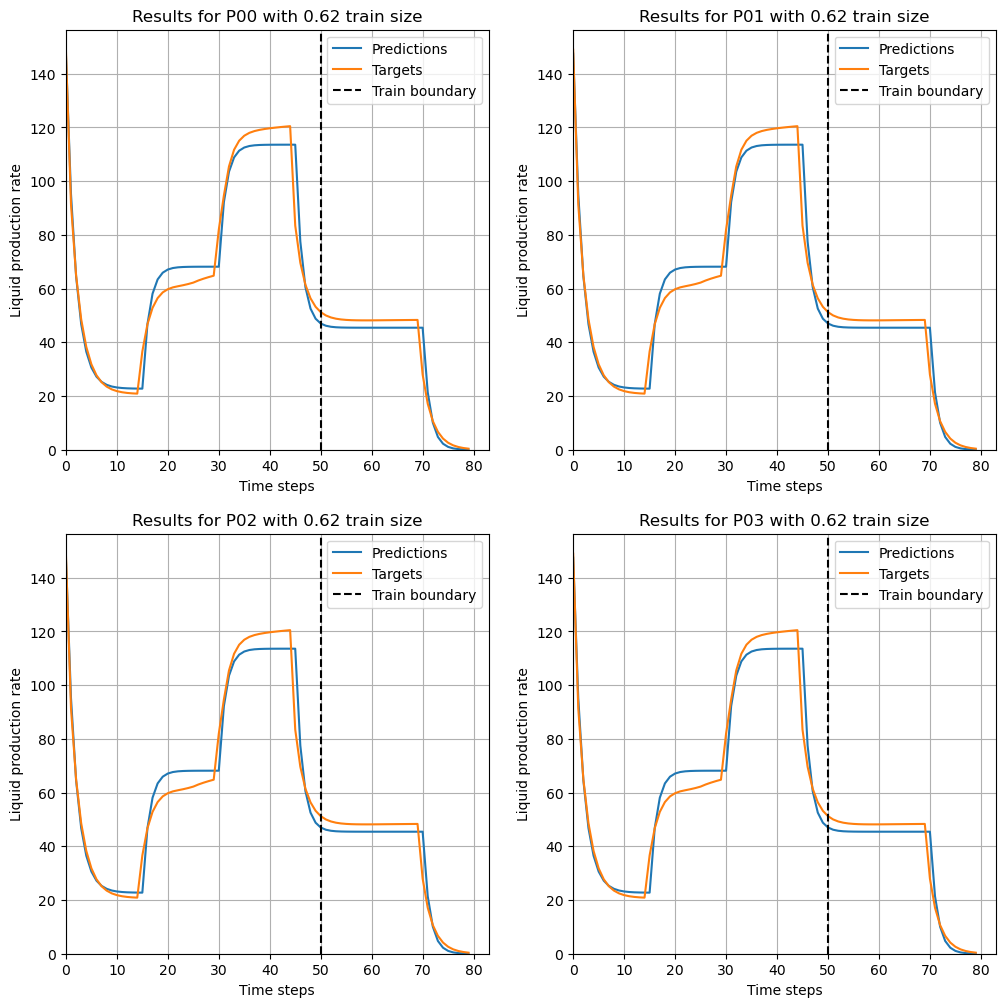

lambda_p: 
 [0.55949201 0.55950371 0.55949015 0.55948774]
tau_p: 
 [1.75032786 1.75030889 1.75033605 1.75033478]
lambda: 
 [0.22852301 0.22852332 0.2285227  0.22852454]
tau: 
 [1.39599343 1.39609636 1.39607324 1.3960291 ]


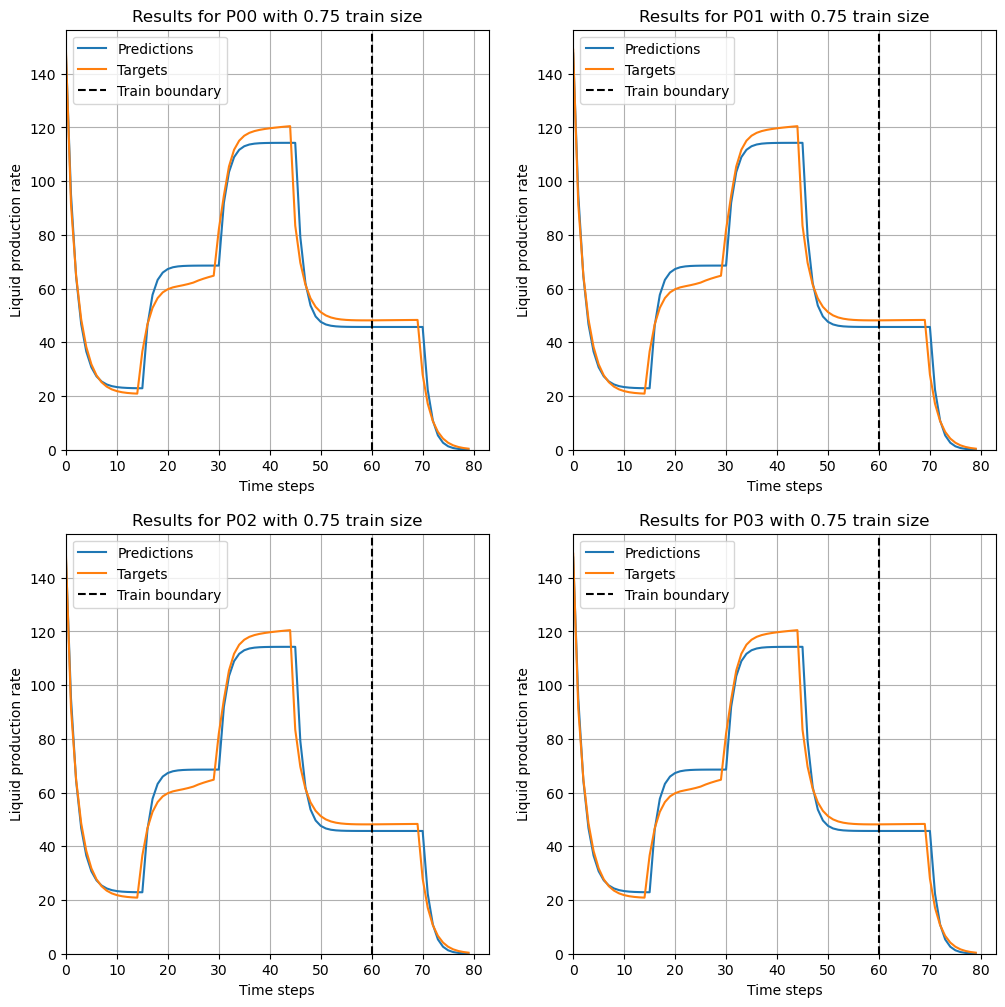

lambda_p: 
 [0.55922593 0.55923489 0.55924483 0.55923026]
tau_p: 
 [1.74819943 1.74823323 1.74824297 1.74822755]
lambda: 
 [0.22938995 0.22939027 0.22939023 0.22939039]
tau: 
 [1.40519286 1.40523624 1.40536775 1.40530693]


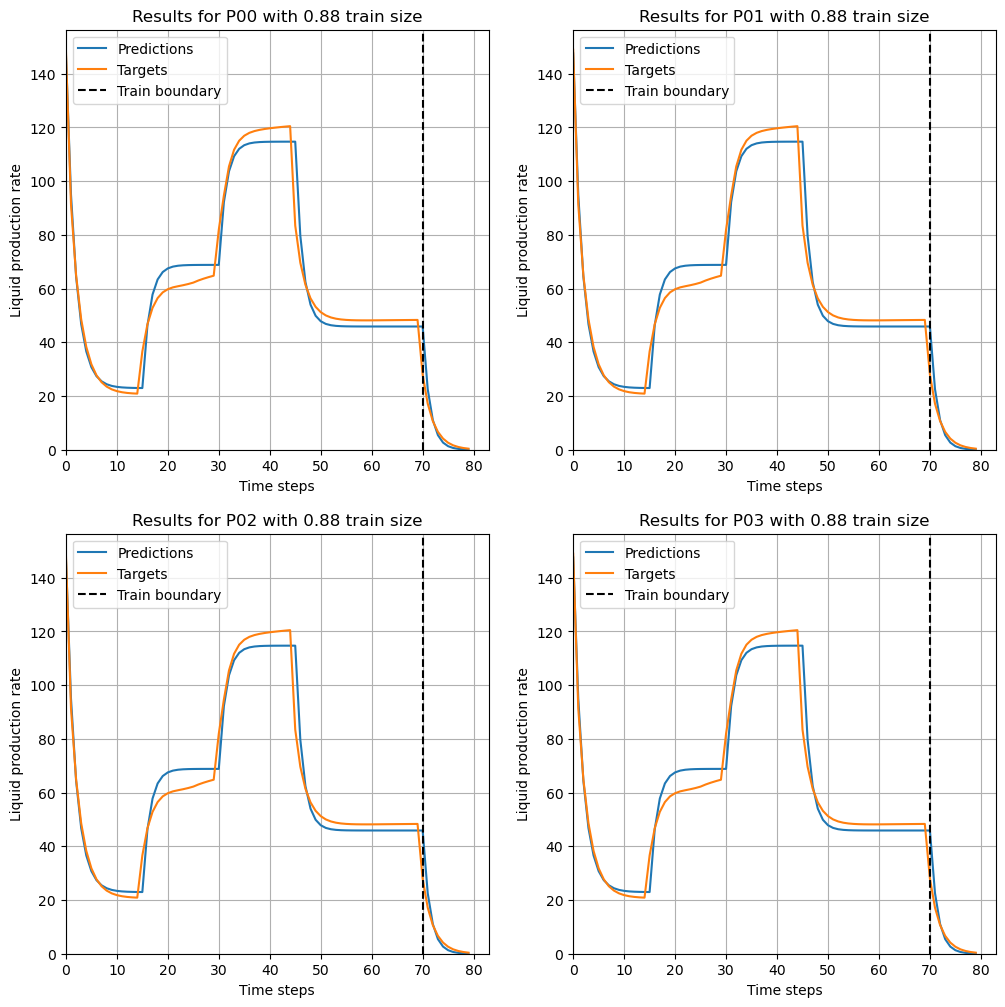

In [17]:
# Let's wrap these functions into one big ```main``` function to simplify the calculation of different cases

def main(train_test_split_boundary, initial_guess,
         type_bounds=[(0,1),(0,None),(0.1,0.5),(0,None)],
         constraints = False):
    # {'type': 'eq', 'fun': lambda x: np.sum(x[8:12]) - 1}
    bnds = []
    for i in range(16):
        if i<4:
            bnds.append(type_bounds[0])
        elif 4<=i<8:
            bnds.append(type_bounds[1])
        elif 8<=i<12:
            bnds.append(type_bounds[2])
        else:
            bnds.append(type_bounds[3])
    if constraints:
        result = scipy.optimize.minimize(obj_func, initial_guess,
                                         bounds=bnds,
                                         args=(dt_cum[1:train_test_split_boundary],
                                               production_rates[1:train_test_split_boundary,:]),
                                         constraints={'type': 'eq', 'fun': lambda x: np.sum(x[8:12]) - 1},
                                         method='SLSQP')
    else:
        result = scipy.optimize.minimize(obj_func, initial_guess,
                                         bounds=bnds,
                                         args=(dt_cum[1:train_test_split_boundary],
                                               production_rates[1:train_test_split_boundary,:]),
                                         method='SLSQP')
    print('lambda_p: \n',result.x[:4])
    print('tau_p: \n',result.x[4:8])
    print('lambda: \n',result.x[8:12])
    print('tau: \n',result.x[12:])
    modeled_rates = model_function(dt_cum[1:], result.x)
    plt.figure(figsize=(12,12))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.plot(modeled_rates[:, i], label='Predictions')
        plt.plot(production_rates[1:, i], label='Targets')
        plt.axvline(x=train_test_split_boundary, ls='--', color='k', label = 'Train boundary')
        plt.grid()
        plt.title(f'Results for P0{i} with {train_test_split_boundary/80:.2f} train size')
        plt.xlabel('Time steps')
        plt.ylabel('Liquid production rate')
        plt.legend()
        plt.xlim(left=0)
        plt.ylim(bottom=0)
    plt.show()

    return result.x, modeled_rates

par_40, mr_40 = main(40, np.ones(16))
par_50, mr_50 = main(50, np.ones(16))
par_60, mr_60 = main(60, np.ones(16))
par_70, mr_70 = main(70, np.ones(16))

### Task 2:

Calculate metrics (MAE, MSE, R$^2$) on the full dataset and compare the results depending on the ratio division during optimization procedure. Make sure that the sum of defined lambda coefficients for each injector (you have only one in this case) is equal to one. If not, use constraint optimization.

In [18]:
MSE = lambda preds, targets: np.linalg.norm(targets - preds, 'fro')**2 / (targets.shape[0]*targets.shape[1])
MAE = lambda preds, targets: np.mean(np.abs(preds - targets))
R2 = lambda preds, targets: 1 - ((preds - targets) ** 2).sum() / ((preds - targets.mean()) ** 2).sum()

In [19]:
def metrics(modeled_rates, production_rates, title=None):
    if title is not None:
        print(title)
    print('MSE: ', MSE(modeled_rates, production_rates).round(2),
          'MAE: ', MAE(modeled_rates, production_rates).round(2),
          'R2: ', R2(modeled_rates, production_rates).round(2))

for mr, label in zip([mr_40, mr_50, mr_60, mr_70], [40, 50,60,70]):
    metrics(mr, production_rates[1:], f'\nFor case with {label/80 :.2f} train size')


For case with 0.50 train size
MSE:  35.2 MAE:  4.12 R2:  0.97

For case with 0.62 train size
MSE:  35.07 MAE:  4.16 R2:  0.97

For case with 0.75 train size
MSE:  34.87 MAE:  4.04 R2:  0.97

For case with 0.88 train size
MSE:  34.9 MAE:  3.98 R2:  0.97


In [20]:
#Check that sum of defined lambda coefficients is equal to one
for par, label in zip([par_40, par_50, par_60, par_70], [40, 50,60,70]):
    print(f'The sum of lambdas for case with {label/80 :.2f} train size equals {np.sum(par[8:12]):.2f}')

The sum of lambdas for case with 0.50 train size equals 0.91
The sum of lambdas for case with 0.62 train size equals 0.91
The sum of lambdas for case with 0.75 train size equals 0.91
The sum of lambdas for case with 0.88 train size equals 0.92


lambda_p: 
 [0.56480306 0.56480654 0.6284096  0.56480682]
tau_p: 
 [1.77767493 1.77767676 2.25659241 1.77767315]
lambda: 
 [0.22984113 0.22984224 0.31047531 0.22984132]
tau: 
 [1.5930178  1.59320101 8.73881524 1.59307777]


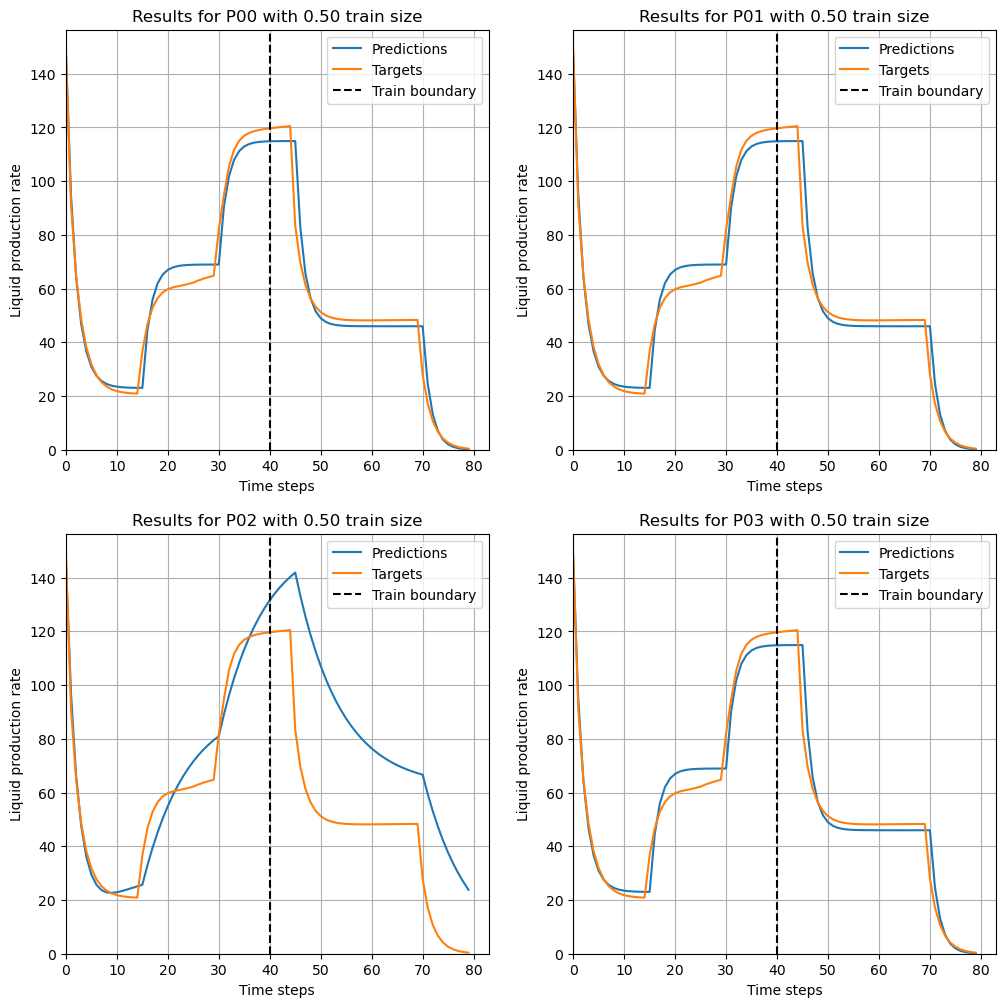

lambda_p: 
 [0.32672267 0.15925564 0.60255039 0.17137022]
tau_p: 
 [36.70252867 94.2099405   2.43918223 51.29495157]
lambda: 
 [0.39872783 0.1825375  0.22656699 0.19216767]
tau: 
 [35.53884229  0.99728542  1.50313155  1.18892053]


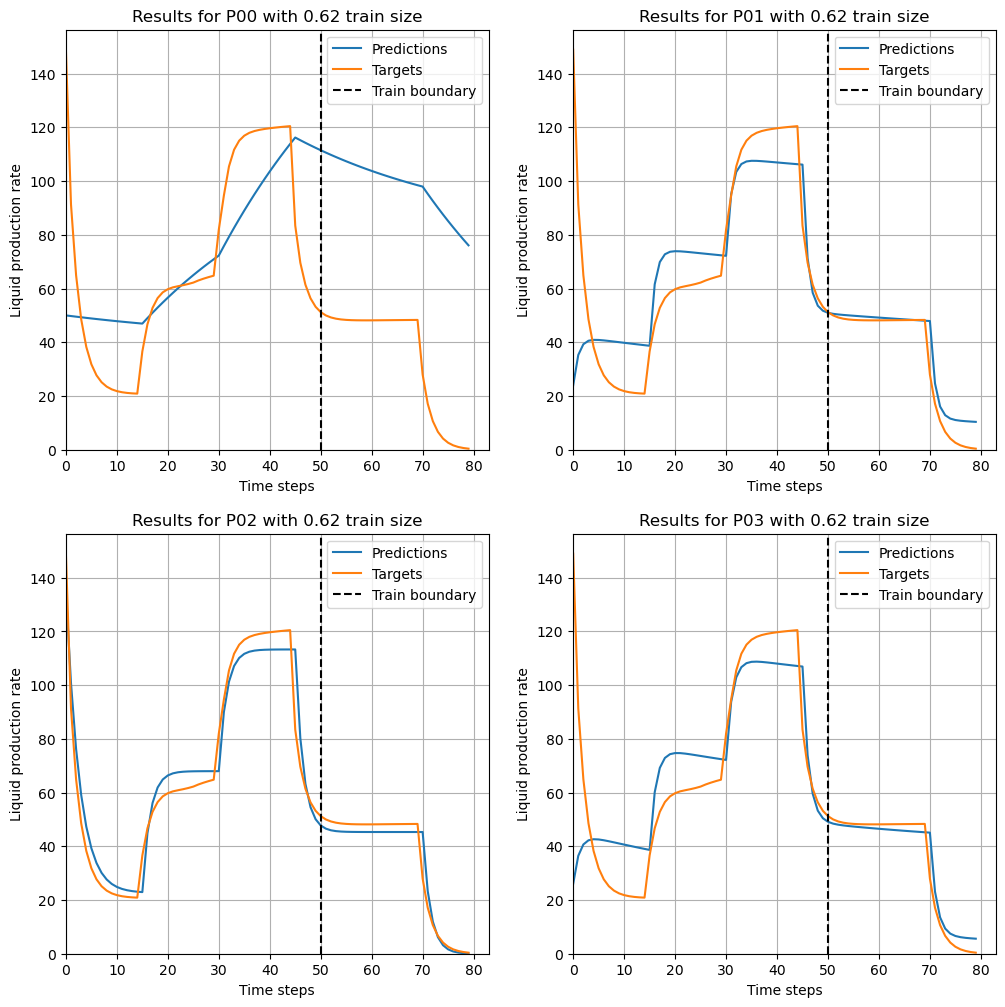

lambda_p: 
 [0.55432517 0.55431805 0.55432251 0.5543224 ]
tau_p: 
 [1.70753227 1.70749274 1.70751076 1.70751078]
lambda: 
 [0.24999917 0.25000001 0.25000045 0.25000037]
tau: 
 [1.65292431 1.65285197 1.65290642 1.65286354]


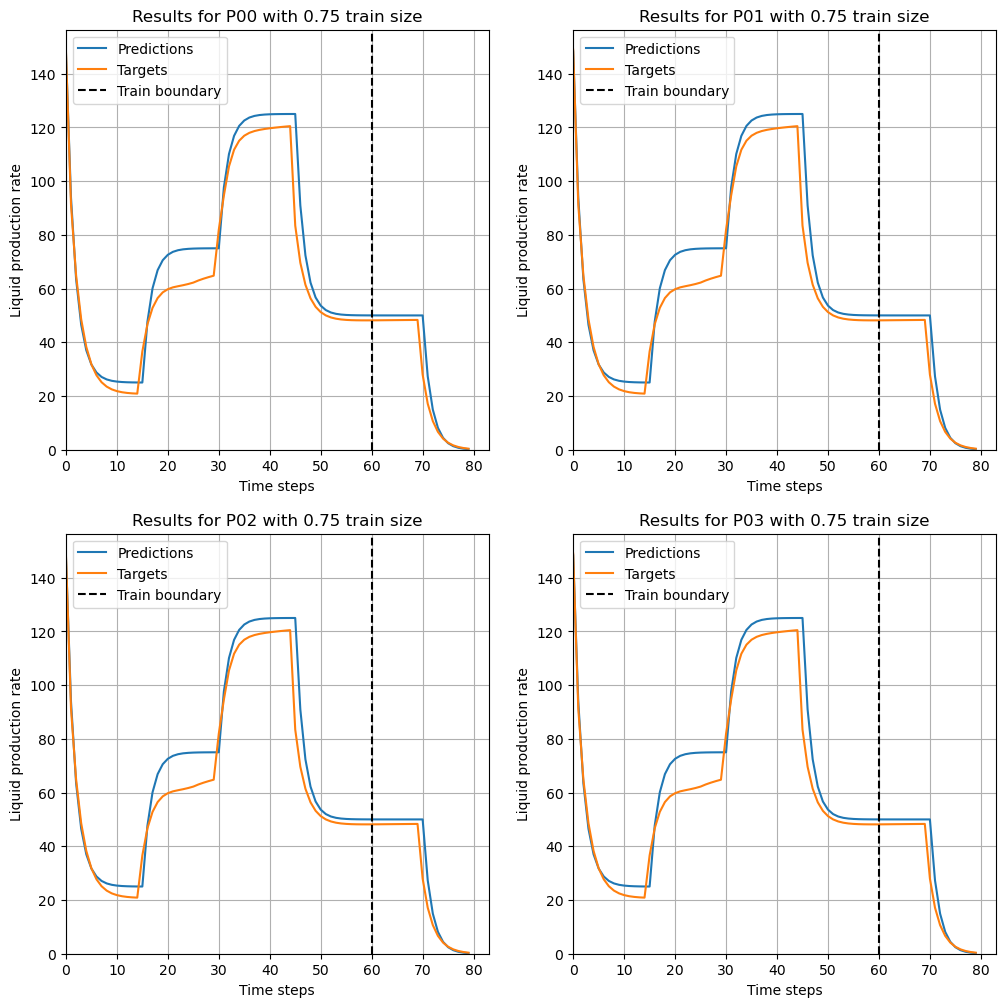

lambda_p: 
 [0.55431572 0.55431214 0.55431176 0.55431592]
tau_p: 
 [1.70747594 1.70743347 1.70743292 1.70745918]
lambda: 
 [0.24999989 0.25000018 0.24999997 0.24999996]
tau: 
 [1.65255227 1.65257707 1.65257025 1.65263245]


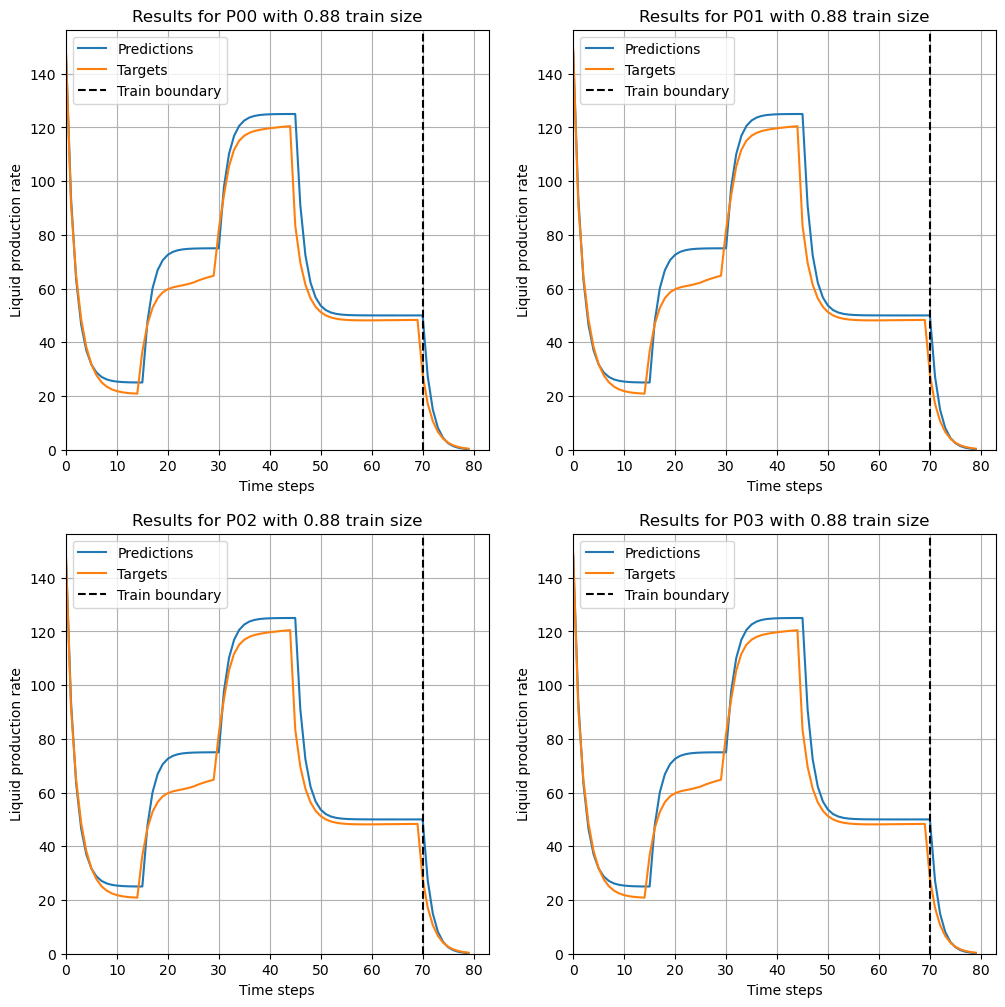


For case with 0.50 train size
MSE:  208.71 MAE:  8.02 R2:  0.84
The sum of lambdas equals 1.00

For case with 0.62 train size
MSE:  690.51 MAE:  15.59 R2:  0.31
The sum of lambdas equals 1.00

For case with 0.75 train size
MSE:  68.82 MAE:  5.48 R2:  0.95
The sum of lambdas equals 1.00

For case with 0.88 train size
MSE:  68.81 MAE:  5.48 R2:  0.95
The sum of lambdas equals 1.00


In [21]:
# Lets use contraints optimization
par_40, mr_40 = main(40, np.ones(16), constraints=True)
par_50, mr_50 = main(50, np.ones(16), constraints=True)
par_60, mr_60 = main(60, np.ones(16), constraints=True)
par_70, mr_70 = main(70, np.ones(16), constraints=True)

for mr, par, label in zip([mr_40, mr_50, mr_60, mr_70],
                          [par_40, par_50, par_60, par_70],
                          [40, 50,60,70]):
    metrics(mr, production_rates[1:], f'\nFor case with {label/80 :.2f} train size')
    print(f'The sum of lambdas equals {np.sum(par[8:12]):.2f}')

### Task 3:

What conclusions can you make about the system analyzing derived parameters? Are there any impermeable or highly permeable channels in the interwell space?


**Conclusions**:

1. The values of $\lambda$ are close to 0.25, which may indicate that the rock has moderately high permeability. The values of $\tau$ are also moderately high, which may indicate that the rock has high capacity.

2. The values of the $\lambda_p$ and $\tau_p$ coefficients for each well may differ slightly, but if the values of these coefficients in general have similar values, then this may indicate some homogeneity of the geological conditions of the field.

3. According to the previous statement, we can say that our reservoir is homogeneous, and there is no impermeable or highly permeable channels in the interwell space.

4. The metrics(MSE, MAE, R$^2$) is improving if the train size is increased in case of **unconstraining** optimization.  In case a constrainig optimizization we have absolutely different behaviour of metrics.

**Unconstraining optimization metrics (depending on training size)**

| Training size/Metrics | .5   | .62   | .75   | .88  |
|-----------------------|------|-------|-------|------|
| MSE                   | 35.2 | 35.07 | 34.87 | 34.9 |
| MAE                   | 4.12 | 4.16  | 4.04  | 3.98 |
| R$^2$                 | .97  | .97   | .97   | .97  |


In my opinion **constraining** optimization give us more physically results, but in small size of training datasets (less than approximately .75) makes the metrics worse.

**Constraining optimization metrics (depending on training size)**

| Training size/Metrics | .5     | .62    | .75   | .88   |
|-----------------------|--------|--------|-------|-------|
| MSE                   | 208.71 | 690.51 | 68.82 | 68.81 |
| MAE                   | 8.02   | 15.59  | 5.48  | 5.48  |
| R$^2$                 | .84    | 0.31   | .95   | .95   |

5. There is one interesting observation for me: in case when training size is .62 worse than case with .5 in constraining optimization. Maybe something breaks when we are fitting lambdas with summing 1. Now I can't answer this question (unfortunately).

6. In general conclusion we can say that CRMP can be useful if we have large previous data about producing/injection dynamic and we can't make good predictions for the long term future (maybe good time term for homogenous reservoir less than .25 time period, but checking needs more experiments).

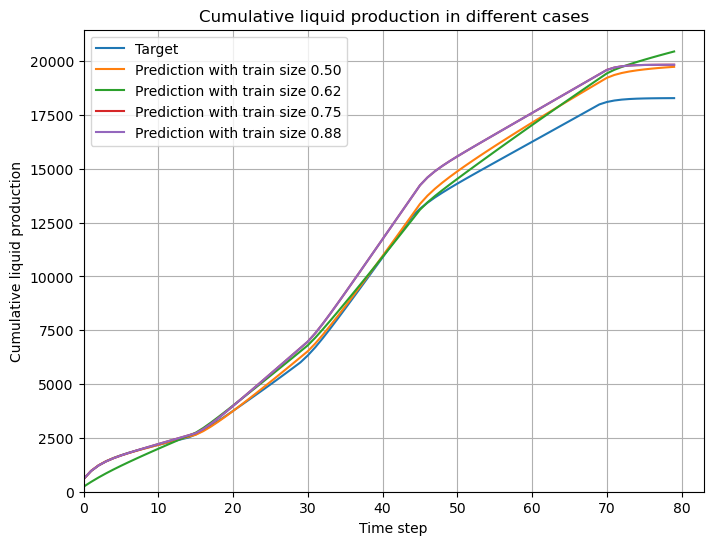

In [22]:
plt.figure(figsize=(8,6))
plt.plot(production_rates[1:,:].sum(1).cumsum(), label='Target')
for mr, label in zip([mr_40, mr_50, mr_60, mr_70],[40, 50, 60, 70]):
    plt.plot(mr.sum(1).cumsum(), label=f'Prediction with train size {label/80 :.2f}')
plt.legend()
plt.ylabel('Cumulative liquid production')
plt.xlabel('Time step')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(True)
plt.title('Cumulative liquid production in different cases')
plt.show()

For cumulative statistics CRMP got not accurate results